In [1]:
from initialization.calculate_w import calculate_w
from initialization.construct_A import construct_A_matrix

**MAX-XORSAT Equation:**

$$
\text{maximize } 3 - \left[ (x_2 \oplus 0) + ((x_1 \oplus x_2) \oplus 1) + (x_1 \oplus 1) \right].
$$

**Expanded Form:**

$$
\text{maximize } \sum_{i=1}^3 \left( 1 - (\text{Constraint}_i \oplus v_i) \right),
$$

where:

$$
\text{Constraint}_1 = x_2, \quad
\text{Constraint}_2 = x_1 \oplus x_2, \quad
\text{Constraint}_3 = x_1,
$$

and:

$$
v = \begin{bmatrix} 0 \\ 1 \\ 1 \end{bmatrix}.
$$


In [101]:
import numpy as np
B = np.array([
    [0, 1],
    [1, 1],
    [1, 0]
])
v = np.array([
    [0],
    [1],
    [1]
])
print("B:\n", B)
print("\nv:\n", v)

B:
 [[0 1]
 [1 1]
 [1 0]]

v:
 [[0]
 [1]
 [1]]


In [102]:
x = np.array([
    [1, 0],
])

print("Maximum value: ", len(B))
print(len(B) - sum((B@x.T + v) % 2)[0])

Maximum value:  3
3


In [ ]:
n = len(B[0])
m, p, r, ell = len(B), 2, 1, 3

# Sparse matrix
A, _ = construct_A_matrix(m, ell, p, r)
w, _ = calculate_w(A)
w

array([ 0.35355339, -0.61237244,  0.61237244, -0.35355339])

In [144]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

init_qregs = QuantumRegister(ell-1, name='k')
initialize_circuit = QuantumCircuit(init_qregs)

In [145]:
initialize_circuit.initialize(w)

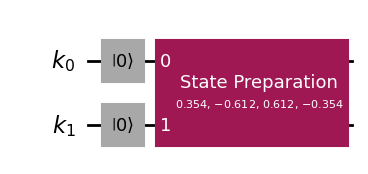

In [146]:
initialize_circuit.decompose().draw('mpl')

In [147]:
from dicke_state_preparation.gates import DickeStatePreparation
from utils import binary_combinations

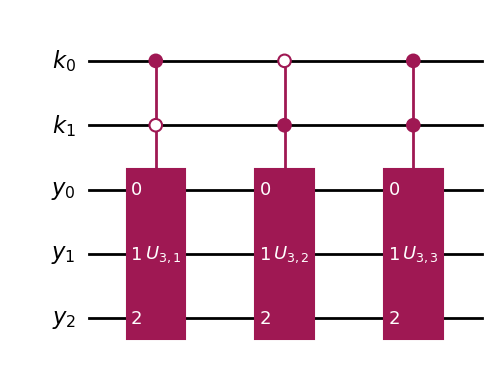

In [152]:
dicke_qregs = QuantumRegister(m, name='y') 
dicke_circuit = QuantumCircuit(init_qregs, dicke_qregs)
ctrl_states = binary_combinations(ell-1)
for k in range(1, 2**(ell-1)):
    dicke_circuit.append(DickeStatePreparation(m, k).to_gate().control(ell-1, ctrl_state=ctrl_states[k]), range(ell-1+m))
dicke_circuit.draw('mpl')

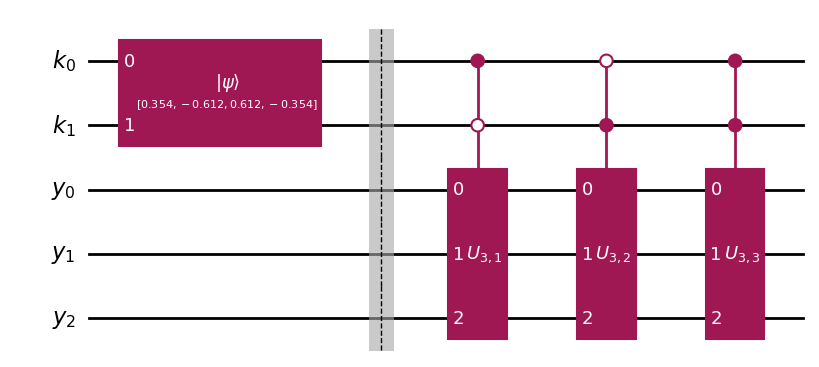

In [153]:
combine_circuit_1 = QuantumCircuit(init_qregs, dicke_qregs)
combine_circuit_1.compose(initialize_circuit, inplace=True)
combine_circuit_1.barrier()
combine_circuit_1.compose(dicke_circuit, inplace=True)
combine_circuit_1.draw('mpl')

In [154]:
from qiskit.quantum_info import Statevector
Statevector(combine_circuit_1).draw('latex')

<IPython.core.display.Latex object>

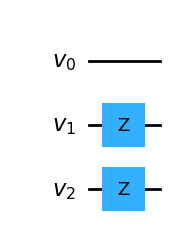

In [155]:
v_phase_qregs = QuantumRegister(m, name='v')
v_phase_flip_circuit = QuantumCircuit(v_phase_qregs)
for i in range(m):
    if v[i][0] == 1:
        v_phase_flip_circuit.z(i)
v_phase_flip_circuit.draw('mpl')

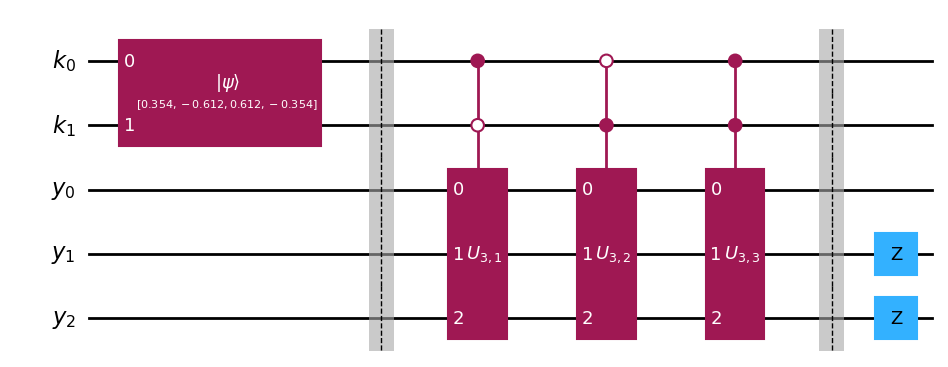

In [157]:
combine_circuit_2 = QuantumCircuit(init_qregs, dicke_qregs)
combine_circuit_2.compose(initialize_circuit, inplace=True)
combine_circuit_2.barrier()
combine_circuit_2.compose(dicke_circuit, inplace=True)
combine_circuit_2.barrier()
combine_circuit_2.compose(v_phase_flip_circuit, qubits=range(ell-1, m+ell-1), inplace=True)
combine_circuit_2.draw('mpl')

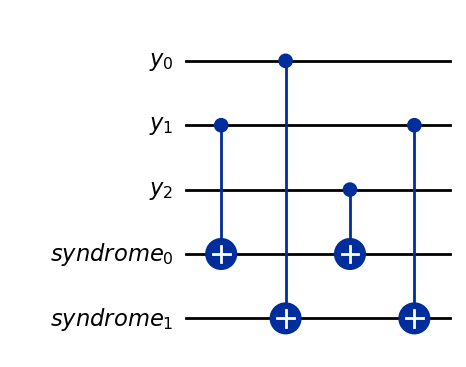

In [158]:
syndrome_qregs = QuantumRegister(n, name='syndrome')
B_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs)
for i in range(n):
    for j in range(m):
        if B.T[i][j] == 1:
            B_circuit.cx(j, m+i)
            
B_circuit.draw('mpl')

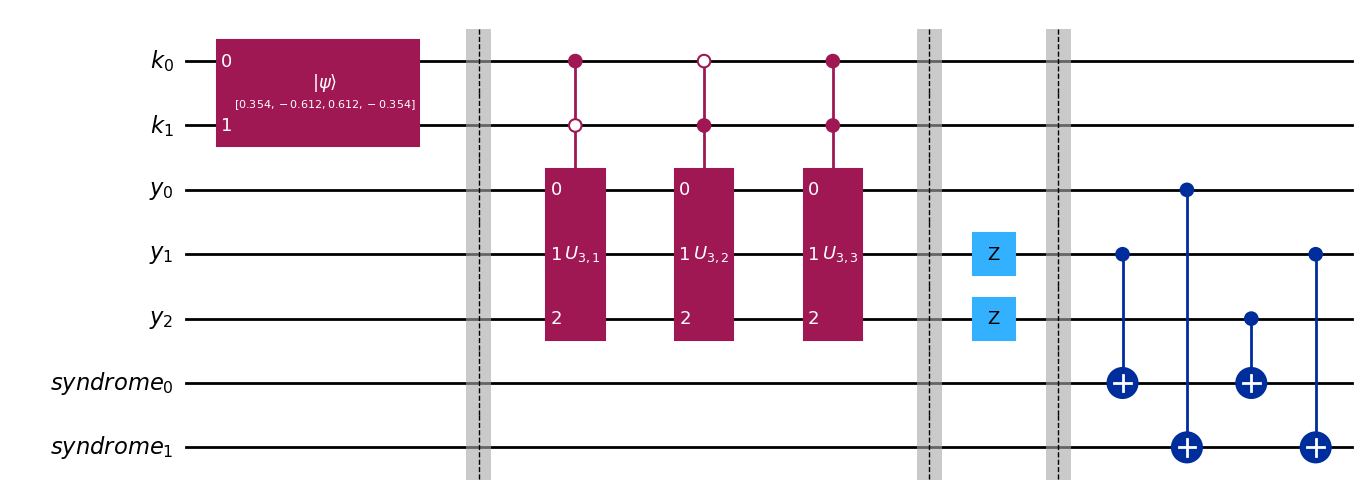

In [219]:
combine_circuit_3 = QuantumCircuit(init_qregs, dicke_qregs, syndrome_qregs)
combine_circuit_3.compose(initialize_circuit, inplace=True)
combine_circuit_3.barrier()
combine_circuit_3.compose(dicke_circuit, inplace=True)
combine_circuit_3.barrier()
combine_circuit_3.compose(v_phase_flip_circuit, qubits=range(ell-1, m+ell-1), inplace=True)
combine_circuit_3.barrier()
combine_circuit_3.compose(B_circuit, qubits=list(range(ell-1, ell-1+m+n)), inplace=True)
combine_circuit_3.draw('mpl')

In [217]:
from qiskit.quantum_info import partial_trace
reduced_density_matrix = partial_trace(Statevector(combine_circuit_3), range(init_qregs.size + dicke_qregs.size))

Statevector(np.diagonal(reduced_density_matrix)).draw('latex')


<IPython.core.display.Latex object>

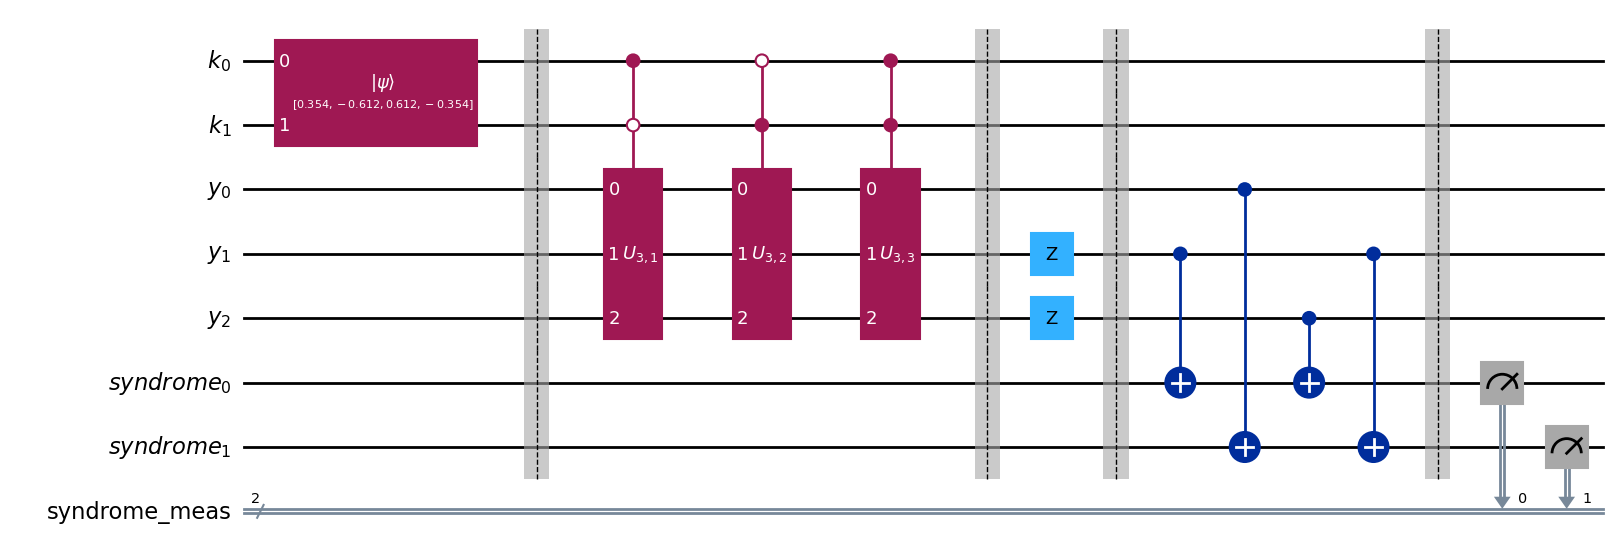

In [177]:
syndrome_cregs = ClassicalRegister(n, name='syndrome_meas')
combine_circuit_4 = QuantumCircuit(init_qregs, dicke_qregs, syndrome_qregs, syndrome_cregs)
combine_circuit_4.compose(initialize_circuit, inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.compose(dicke_circuit, inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.compose(v_phase_flip_circuit, qubits=range(ell-1, m+ell-1), inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.compose(B_circuit, qubits=list(range(ell-1, ell-1+m+n)), inplace=True)
combine_circuit_4.barrier()
combine_circuit_4.measure(syndrome_qregs, syndrome_cregs)
combine_circuit_4.draw('mpl')

In [199]:
from qiskit_aer import AerSimulator
from qiskit import transpile

simulator = AerSimulator()
transpiled_circuit = transpile(combine_circuit_4, backend=simulator)
result = simulator.run(transpiled_circuit, shots=10000).result()
counts = result.get_counts(combine_circuit_4)
counts

{'00': 2512, '01': 2489, '11': 2465, '10': 2534}

In [200]:
B

array([[0, 1],
       [1, 1],
       [1, 0]])

In [201]:
v

array([[0],
       [1],
       [1]])

In [ ]:
import numpy as np

def gaussian_elimination_mod2(B, s):
    B = B.astype(int) % 2  # Ensure binary field
    s = s.astype(int) % 2  # Ensure binary field
    
    # Augmented matrix [B | s]
    augmented_matrix = np.hstack((B, s))
    rows, cols = B.shape
    
    # Forward elimination
    for col in range(cols):
        # Find a row with a leading 1 in the current column
        for row in range(col, rows):
            if augmented_matrix[row, col] == 1:
                # Swap rows if necessary
                if row != col:
                    augmented_matrix[[col, row]] = augmented_matrix[[row, col]]
                break
        else:
            # If no leading 1 is found, continue to the next column
            continue

        # Eliminate the current column for all rows below the pivot row
        for row in range(col + 1, rows):
            if augmented_matrix[row, col] == 1:
                augmented_matrix[row] ^= augmented_matrix[col]

    # Back substitution
    x = np.zeros((cols, 1), dtype=int)
    for row in range(rows - 1, -1, -1):
        pivot_col = np.argmax(augmented_matrix[row, :-1])
        if augmented_matrix[row, pivot_col] == 1:
            x[pivot_col] = augmented_matrix[row, -1]
            # Subtract the current row from rows above
            for r in range(row):
                if augmented_matrix[r, pivot_col] == 1:
                    augmented_matrix[r, -1] ^= x[pivot_col, 0]

    return x

# Define the input matrices
B = np.array([
    [1, 0],
    [1, 1],
    [0, 1]
])
print("B.T: \n", B.T)
s = np.array([
    [0],
    [1]
])

# Solve the system
solution = gaussian_elimination_mod2(B.T, s)
print("Solution x:")
print(solution)


B.T: 
 [[1 1 0]
 [0 1 1]]
[[1 1 0 0]
 [0 1 1 1]]
[[1 1 0 0]
 [0 1 1 1]]
[[1 1 0 1]
 [0 1 1 1]]
Solution x:
[[1]
 [1]
 [0]]
